# MC920 - Trabalho 0

Rafael Sartori M. Santos, 186154

## Problema

O objetivo é realizar processamento básico em imagens, preferindo a solução que utiliza vetorização.

## Organização:

* **Primeiro trecho**: base para processamento geral (abrir, salvar, mostrar imagens)
* **Trechos do trabalho**: utilizar processamento geral para alterar e produzir imagens de acordo com cada etapa do enunciado

### Observação:

Para executar corretamente todos os programas, é necessário executar todos os trechos de código anteriores (em ordem). Ou, no mínimo, o primeiro, pois possui definições.

## Soluções

Utilizarei `matplotlib` para imprimir imagens no relatório, `numpy` para executar as transformações de forma otimizada, interface OpenCV (`cv2`) para Python para abrir e salvar imagens no formato desejado (PNG), `glob` e `os` (padrão de Python) para trabalhar com as pastas e arquivos.

### Trecho base

Base importante para o resto do arquivo são:
* `imagens`: dicionário onde a chave é o caminho até o arquivo da imagem original (para salvarmos facilmente em outra localização após editado) e o valor é a imagem aberta utilizando OpenCV.
* `CAMINHO_IMAGEM`: caminho até a pasta que contém imagens a serem utilizadas em todo projeto.
* **`salvar_imagem(caminho, pasta, imagem)`**: função para salvar a imagem numa pasta customizada dado caminho original da imagem (utilizará a variável global `CAMINHO_IMAGEM`.
* **`mostar_imagem(imagem)`**: atalho para mostrarmos as imagens utilizando `matplotlib`

In [1]:
from matplotlib import pyplot as plt # para gráficos e imagens
import numpy as np # numpy para transformações
import glob # para abrir todos os PNGs da pasta ../Imagem/
import cv2 # OpenCV para lidar com imagens
import os # para criar pasta de saída de imagens


CAMINHO_IMAGEM = '../Imagens/'

## Carregamos todas as imagens num dicionário
## Chave = caminho da imagem
## Valor = imagem
imagens = {}
# Para todas as imagens...
for caminho in glob.glob('{0}*.png'.format(CAMINHO_IMAGEM)):
    # Carregamos imagem utilizando OpenCV
    imagem = cv2.imread(caminho, cv2.IMREAD_UNCHANGED)
    # Guardamos no dicionário com o caminho original
    imagens[caminho] = imagem
    

## Função para salvar a imagem
## Caminho da imagem original
def salvar_imagem(caminho, pasta, imagem):
    # Garantimos que o diretório existe
    try:
        os.makedirs(pasta)
    except FileExistsError:
        pass
    # Utilizamos OpenCV para salvar imagem no novo caminho
    cv2.imwrite(caminho.replace(CAMINHO_IMAGEM, pasta), imagem)

    
## Função para mostrar imagem utilizando matplotlib
def mostrar_imagem(imagem):
    # Criamos um plot e adicionamos a imagem
    plt.imshow(imagem, cmap='gray', interpolation='bicubic')
    plt.show()

### Transformação de intensidade

Transformaremos as intensidades de forma a obtermos o negativo.

Para transformar em negativo, temos que trocar intensidades altas de luz por baixas e vice-versa. Portanto, escolhi a função de transformação dada por:
```
f(x) = 255 - x
```
pois, dessa forma, temos de forma linear intensidade 0 para pontos claros (originalmente 255) e intensidade 255 para pontos escuros (originalmente 0).

**Limitação importante:** para profundidades diferentes de 8 _bits_ teríamos que alterar o valor mágico 255.

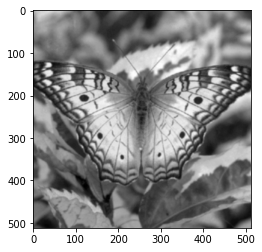

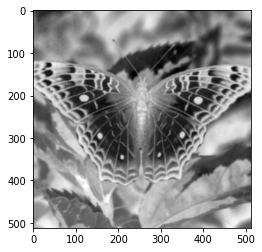

In [2]:
CAMINHO_SALVAR = '1.intensidade/'
primeira = True

# Para cada imagem...
for caminho, imagem in imagens.items():
    # Carregamos a imagem em um vetor numpy
    img = np.array(imagem)
    
    # Aplicamos a inversão simétrica (255 -> 0, 254 -> 1 etc)
    # f(x) = 255 - x
    img = (np.ones(img.shape) * 255) - img
    
    # Salvamos as imagens
    salvar_imagem(caminho, CAMINHO_SALVAR, img)
    
    # Se é a primeira imagem, mostramos o antes e depois
    if primeira:
        primeira = False
        mostrar_imagem(imagem)
        mostrar_imagem(img)

### Ajuste de brilho

Aplicamos correção gama para ajustar o brilho. Para isso, aplicamos uma normalização (`[0, 255] -> [0, 1]`) e transformamos com um dado gama:
```
f(x) = x^(1 / gama) | gama
```
Após essa transformação, retornamos ao intervalo padrão `[0, 255]` e salvamos.

Faremos para vários gamas, inclusive para um menor que 1, que tem como resultado a diminuição de brilho, que é também bastante interessante para correção de imagens.

**Limitação importante:** para profundidades diferentes de 8 _bits_ teríamos que alterar o valor mágico 255.

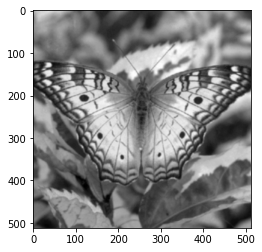

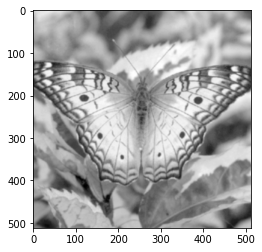

In [3]:
CAMINHO_SALVAR = '2.brilho/'
primeira = True

# Para cada imagem...
for caminho, imagem in imagens.items():
    # Carregamos a imagem em um vetor numpy
    img = np.array(imagem)
    
    # Normalizamos: [0, 255] -> [0, 1]
    img_norm = img / 255
    
    # Para cada gama, criamos uma cópia da imagem normalizada
    for gama in [0.7, 1.5, 2.5, 3.5]:
        # Aplicamos a equação gama
        # f(x) = x^(1/gama)
        img_ = np.power(img_norm.copy(), 1 / gama)
        
        # Retornamos ao natural: [0, 1] -> [0, 255]
        img_ = img_ * 255

        # Salvamos as imagens
        salvar_imagem(caminho.replace('.png', '-gama{0}.png'.format(gama)), CAMINHO_SALVAR, img_)
    
    # Se é a primeira imagem, mostramos o antes e depois
    if primeira:
        primeira = False
        mostrar_imagem(imagem)
        mostrar_imagem(img_)

### Planos de bits

Selecionamos um plano específico da imagem.

Seja `a_(m - 1)*2^(m - 1) + a_(m - 2)*2^(m - 2) + ... + a_0*2^0` o nível de cinza da imagem, então o plano `n` da imagem é composto apenas pelos fatores `a_n`.

A transformação então é:
```
f(x) = x & (0b1 << n) | n-ésimo plano
```
ou seja, selecionamos através da operação `AND` _bit_ a _bit_ apenas uma faixa.

Faremos para vários planos. É interessante notar que em alguns podemos ver alguns trechos de destaque da imagem.

**Limitação importante:** para profundidades diferentes de 8 _bits_ teríamos que alterar o valor mágico 255.

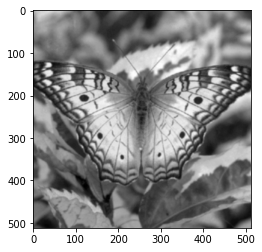

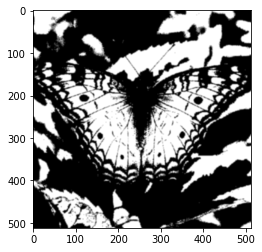

In [4]:
CAMINHO_SALVAR = '3.bits/'
primeira = True

# Para cada imagem...
for caminho, imagem in imagens.items():
    # Carregamos a imagem em um vetor numpy
    img = np.array(imagem)

    # Para cada plano, selecionamos o fator utilizando uma cópia da original
    for plano in [0, 4, 7]:
        # Selecionamos o único fator a_n do plano n
        # f(x) = x & (0b1 << n)
        img_ = np.bitwise_and(img.copy(), 0b1 << plano)
        # Aumentamos a intensidade para visualizarmos
        img_[img_ > 0] = 255

        # Salvamos as imagens
        salvar_imagem(caminho.replace('.png', '-fator{0}.png'.format(plano)), CAMINHO_SALVAR, img_)
    
    # Se é a primeira imagem, mostramos o antes e depois
    if primeira:
        primeira = False
        mostrar_imagem(imagem)
        mostrar_imagem(img_)

### Mosaico

Movendo pedaços da imagem como um quebra-cabeça.

Fazemos isso com a divisão entre trechos de igual tamanho verticalmente e depois horizontalmente. Incrementamos um contador para cada divisão feita de forma a identificarmos a posição da imagem original que o corte representa.

Aplicamos a movimentação através de uma matriz, que indica de que forma iremos unir horizontal e verticalmente os trechos diferentes. Após tudo concatenado por um acumulador, salvamos a imagem.

Não possui limitações de profundidade através de números mágicos.

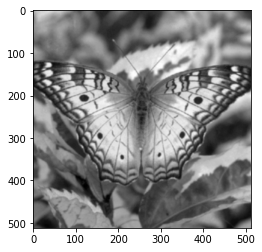

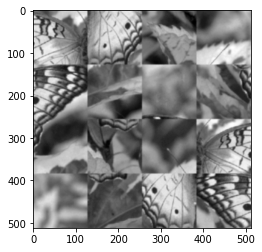

In [5]:
CAMINHO_SALVAR = '4.mosaico/'
primeira = True

# Para cada imagem...
for caminho, imagem in imagens.items():
    # Carregamos a imagem em um vetor numpy
    imagem = np.array(imagem)
    
    # Dividimos a imagem em 4x4 = 16 blocos iguais e guardamos num dicionário
    quadrantes = {}
    i = 1
    for vert in np.vsplit(imagem, 4):
        for horiz in np.hsplit(vert, 4):
            # Guardamos o corte com o índice do "quadrante" que estamos
            quadrantes[i] = horiz
            i += 1
    
    # Índices que remapearemos
    mosaico = [[6, 11, 13, 3],
                [8, 16, 1, 9],
                [12, 14, 2, 7],
                [4, 15, 10, 5]]
    # Para imagem natural:
    #mosaico = np.arange(16).reshape(4, 4)
    
    # Refazemos a imagem utilizando esses indices:
    img_ = None
    for linha in mosaico:
        # Fazemos a linha com junção horizontal
        img = np.hstack([quadrantes[indice] for indice in linha])
        # Substituímos a variável acumuladora 'img_' ou anexamos a linha verticalmente
        if img_ is None:
            img_ = img
        else:
            img_ = np.vstack([img_, img])
            
    # Salvamos as imagens
    salvar_imagem(caminho, CAMINHO_SALVAR, img_)

    # Se é a primeira imagem, mostramos o antes e depois
    if primeira:
        primeira = False
        mostrar_imagem(imagem)
        mostrar_imagem(img_)

### Combinação de imagem

Aplicando média ponderada entre duas imagens diferentes, da forma que, quando dado peso, temos:
```
f(x, y) = peso * x + (1 - peso) * y | peso
```
pois a soma de todos os pesos devem compor a profundidade toda da imagem (ou estaríamos limitando-a).

Não possui limitações de profundidade através de números mágicos, mas imagens de diferentes profundidades podem causar problemas.

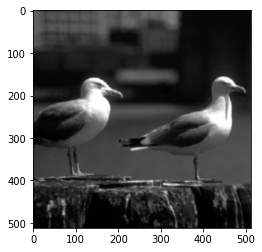

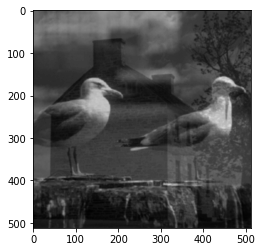

In [6]:
CAMINHO_SALVAR = '5.combinacao/'
primeira = True

# Pegamos duas imagens com vetor numpy
imagem1 = np.array(imagens['../Imagens/house.png'])
imagem2 = np.array(imagens['../Imagens/seagull.png'])


# Para cada combinação...
for combinacao in [0.3, 0.5, 0.8]:
    # Pegamos a média ponderada entre imagem 1 e 2
    img_ = imagem1 * combinacao + imagem2 * (1 - combinacao)
    
    # Salvamos as imagens
    salvar_imagem(caminho.replace('.png', '-combinacao{0}.png'.format(combinacao)), CAMINHO_SALVAR, img_)
    
    # Se é a primeira imagem, mostramos o antes e depois
    if primeira:
        primeira = False
        mostrar_imagem(imagem)
        mostrar_imagem(img_)